In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop, Adam
from sklearn.metrics import confusion_matrix
from tensorflow.keras import callbacks
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator



import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## Aknowledgements

These four notebooks below taught me a lot about CNNs, they were, in my opinion, the most complete kernels about the topic in this competition.

* https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6
* https://www.kaggle.com/cdeotte/25-million-images-0-99757-mnist
* https://www.kaggle.com/cdeotte/how-to-choose-cnn-architecture-mnist
* https://www.kaggle.com/kanncaa1/convolutional-neural-network-cnn-tutorial

# Steps to create a CNN

## 1 - Load the data and define the variables 

In [ ]:
# Load the data
train = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

# Create the X_train and y_train variables 
X_train = train.drop('label', axis=1)
y_train = train.label
print(f'X_train = {X_train.shape}')
print(f'test = {test.shape}')

# Set the plots size
sns.set(rc={'figure.figsize':(10,7)})
sns.countplot(y_train)

## 2 - Normalize, reshape, encode the output and split the data into train and test variables

In [ ]:
# Normalize the data 
X_train = X_train / 255.0
test = test / 255.0

# Reshape the data
X_train = X_train.values.reshape(-1, 28, 28, 1)
test = test.values.reshape(-1, 28, 28, 1)

# label encoding 
y_train = to_categorical(y_train, num_classes = 10)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=5)

print(f'X_train = {X_train.shape}')
print(f'test = {test.shape}')

In [ ]:
# Take a look at the data
rows = 5 # defining no. of rows in figure
cols = 6 # defining no. of colums in figure

f = plt.figure(figsize=(2*cols,2*rows)) # defining a figure 

for i in range(rows*cols): 
    f.add_subplot(rows,cols,i+1) # adding sub plot to figure on each iteration
    plt.imshow(X_train[i].reshape([28,28]), cmap="Blues") 
    plt.axis("off")

## 3 - Create the CNN model

* The kernel size does not need to be 3 by 3 matrix. It can be 5 by 5 or 7 by 7.
* kernels detects features like edges or convex shapes. Example, if out input is dog, feature detector can detect features like ear or tail of the dog.
* feature map = conv(input image, feature detector). Element wise multiplication of matrices. feature map = convolved feature
* We reduce the size of image. This is important bc code runs faster. However, we lost information.
* We create multiple feature maps bc we use multiple feature detectors(filters).

In [ ]:
# CNN

model = Sequential([
    layers.Conv2D(filters = 32, kernel_size = (3,3), padding = 'Same', activation ='relu', input_shape = (28,28,1)),
    layers.Conv2D(filters = 32, kernel_size = (3,3), padding = 'Same', activation ='relu'),
    layers.MaxPool2D(pool_size=(2,2)),
    layers.Dropout(0.1),
    
    layers.Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', activation ='relu'),
    layers.Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', activation ='relu'),
    layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    layers.Dropout(0.1),
    
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(10, activation='softmax'),
])

## 4 - Define the optimizer

The ADAM optimizer will be used, we are gonna change the learning rate, after that, compile the model.

In [ ]:
# optimizer 

optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
#optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

## 5 - Create an annealer

In order to make the olgorithm converges to the global minimum of the loss fuction, we will define an annealing method to the learning rate, meaning that the LR will decrease during trainning reaching the global minimum instead of falling into the local minima.

With the ReduceLROnPlateau function from Keras.callbacks, the LR will be reduced by half if the accuracy is not improved after 3 epochs.

In [ ]:
# Set a learning rate annealer

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3,  
                                            factor=0.5, 
                                            min_lr=0.00001)

## 6 - Augment the data

To avoid the overfitting problem, it's necessary to expand artificially our handwritten digit dataset. By altering the training data with small transformations we are able to reproduce the variations occuring when someone is writing a digit.

Methods like the one described above that alter the training data in ways that change the array representation while keeping the label the same are known as "data augmentation" techniques. Some popular augmentations used are: grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and more.

In [ ]:
# Data Augmentation

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # dimesion reduction
        rotation_range=5,  # randomly rotate images in the range 5 degrees
        zoom_range = 0.1, # Randomly zoom image 10%
        width_shift_range=0.1,  # randomly shift images horizontally 10%
        height_shift_range=0.1,  # randomly shift images vertically 10%
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

## 6 - Fit the model 

Say you have a dataset of 10 examples (or samples). You have a batch size of 2, and you've specified you want the algorithm to run for 3 epochs. Therefore, in each epoch, you have 5 batches (10/2 = 5). Each batch gets passed through the algorithm, therefore you have 5 iterations per epoch.

reference: https://stackoverflow.com/questions/4752626/epoch-vs-iteration-when-training-neural-networks

In [ ]:
# Fit the model

epochs = 35
batch_size = 90

history = model.fit(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_test,y_test),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size,
                              callbacks=[learning_rate_reduction])

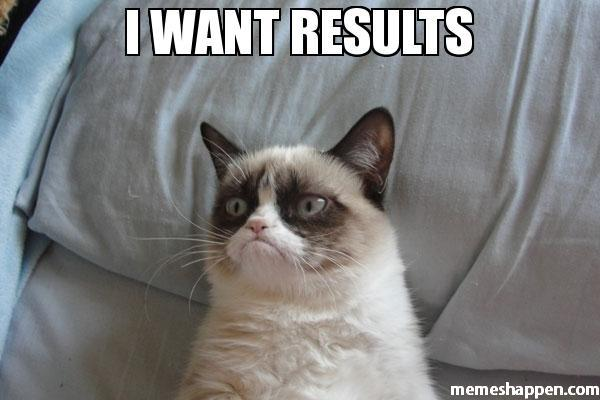

## Let's plot the results and take a look at the confusion matrix

In [ ]:
# Plot the loss and val_loss along with accuracy ans val_accuracy

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()

In [ ]:
# confusion matrix

# Predict the values from the validation dataset
Y_pred = model.predict(X_test)

# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 

# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 

# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix

f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## Summary

it seems that our CNN has some troubles with the 4 digits, they are misclassified as 9. Sometimes it is very difficult to catch the difference between 4 and 9 when the person has a terrible handwriting. Our algorithm goes through the same problems we do.

Let's take a look at some errors we got

In [ ]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_test[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

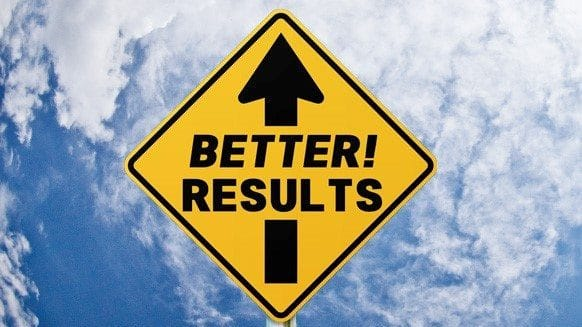

## Extend the data

Let's extend the data, maybe our results are going to improve.

In [ ]:
mnist = tf.keras.datasets.mnist
(X_train_mnist, y_train_mnist), (X_val_mnist, y_val_mnist) = mnist.load_data()

In [ ]:
y_train_mnist = np.array(pd.get_dummies(pd.Series(y_train_mnist)))
y_test_mnist = np.array(pd.get_dummies(pd.Series(y_val_mnist)))

In [ ]:
X_train_mnist = X_train_mnist.reshape(-1, 28, 28, 1)
X_test_mnist = X_val_mnist.reshape(-1, 28, 28, 1)
X_train_mnist = X_train_mnist / 255
X_test_mnist = X_test_mnist /255

In [ ]:
X_train_ext = np.concatenate((X_train, X_train_mnist), axis = 0)
X_test_ext = np.concatenate((X_test, X_test_mnist), axis = 0)
y_train_ext = np.concatenate((y_train, y_train_mnist), axis = 0)
y_test_ext = np.concatenate((y_test, y_test_mnist), axis = 0)

In [ ]:
epochs = 100
batch_size = 90

history = model.fit(datagen.flow(X_train_ext,y_train_ext, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_test,y_test),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size,
                              callbacks=[learning_rate_reduction])

In [ ]:
# Plot the loss and val_loss along with accuracy ans val_accuracy

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()

In [ ]:
# confusion matrix

# Predict the values from the validation dataset
Y_pred = model.predict(X_test)

# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 

# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 

# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix

f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_test[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

## Summary 

As we can see, extending the data was an exelent choice, our predictions improved greatly

## Submit the results

In [ ]:
pred = model.predict(test)

pred = np.argmax(pred, axis=1)

pred = pd.Series(pred, name='Label')

submission = pd.concat([pd.Series(range(1, 28001), name='ImageID'), pred], axis=1)
submission.to_csv('predictions11.csv', index=False)

submission